In [1]:
import time, sys, os
import h5py
import numpy as np
import scipy
from matplotlib.pyplot import *

from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})


In [2]:
import fsps
import sedpy
import prospect
import emcee
import astropy
import math
from astropy.cosmology import WMAP9

In [3]:
def build_obs(snr=10, **extras):
    from prospect.utils.obsutils import fix_obs
    import sedpy

    obs = {}
    
    galex = ['galex_FUV', 'galex_NUV']
    twomass = ['twomass_{}'.format(b) for b in ['J', 'H', 'Ks']]
    sdss = ['sdss_{0}0'.format(b) for b in ['u', 'g', 'r', 'i', 'z']]
    
    filternames = galex + twomass + sdss
    
    obs["filters"] = sedpy.observate.load_filters(filternames)

    M_AB = np.array([17.55, 17.18, 13.47, 13.21, 13.43, 16.718, 15.213, 14.515,
                     14.125, 13.852])
    M_AB_unc = ([0.10, 0.11, 0.04, 0.05, 0.08, 0.016, 0.003, 0.003, 0.003, 0.005])

    mags = 10**(-0.4*M_AB)

    mag_down = [x-y for (x,y) in zip(M_AB, M_AB_unc)]
    flux_down = [10**(-0.4*x) for x in mag_down]
    flux_uncertainty = [y-x for (x,y) in zip(mags, flux_down)]
    
    obs['maggies'] = np.array(mags)
    obs['maggies_unc'] = np.array(flux_uncertainty)


    # Now we need a mask, which says which flux values to consider in the likelihood.
    # IMPORTANT: the mask is *True* for values that you *want* to fit, 
    # and *False* for values you want to ignore.  Here we ignore the spitzer bands.
    #obs["phot_mask"] = np.array(['sdss' not in f.name for f in obs["filters"]])

    obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])

    obs["wavelength"] = None
    
    obs["spectrum"] = None
    
    obs['unc'] = None
    
    obs['mask'] = None

    obs = fix_obs(obs)

    return obs

In [4]:
run_params = {}
run_params["snr"] = 10.0
run_params["ldist"] = 83.6
run_params["object_redshift"] = 0.01835
run_params["add_duste"] = True
run_params["fixed_metallicity"] = None

Obs Dictionary Keys:

dict_keys(['mask', 'maggies_unc', 'phot_mask', 'ndof', 'filternames', 'wavelength', 'maggies', 'filters', 'spectrum', 'unc', 'phot_wave', 'logify_spectrum'])

--------
Filter objects:

[<class 'sedpy.observate.Filter'>(galex_FUV), <class 'sedpy.observate.Filter'>(galex_NUV), <class 'sedpy.observate.Filter'>(twomass_J), <class 'sedpy.observate.Filter'>(twomass_H), <class 'sedpy.observate.Filter'>(twomass_Ks), <class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(sdss_g0), <class 'sedpy.observate.Filter'>(sdss_r0), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(sdss_z0)]
[0.000e+00 3.000e-04 4.000e-04 3.000e-04 9.000e-04 3.300e-03 1.010e-02
 3.370e-02 8.220e-02 1.497e-01 2.359e-01 3.166e-01 3.683e-01 4.075e-01
 4.078e-01 3.686e-01 3.838e-01 3.751e-01 3.806e-01 3.747e-01 3.686e-01
 3.610e-01 3.494e-01 3.409e-01 2.055e-01 3.235e-01 3.147e-01 3.051e-01
 2.955e-01 2.882e-01 2.861e-01 2.873e-01 2.842e-01 2.705e-01 2.379e

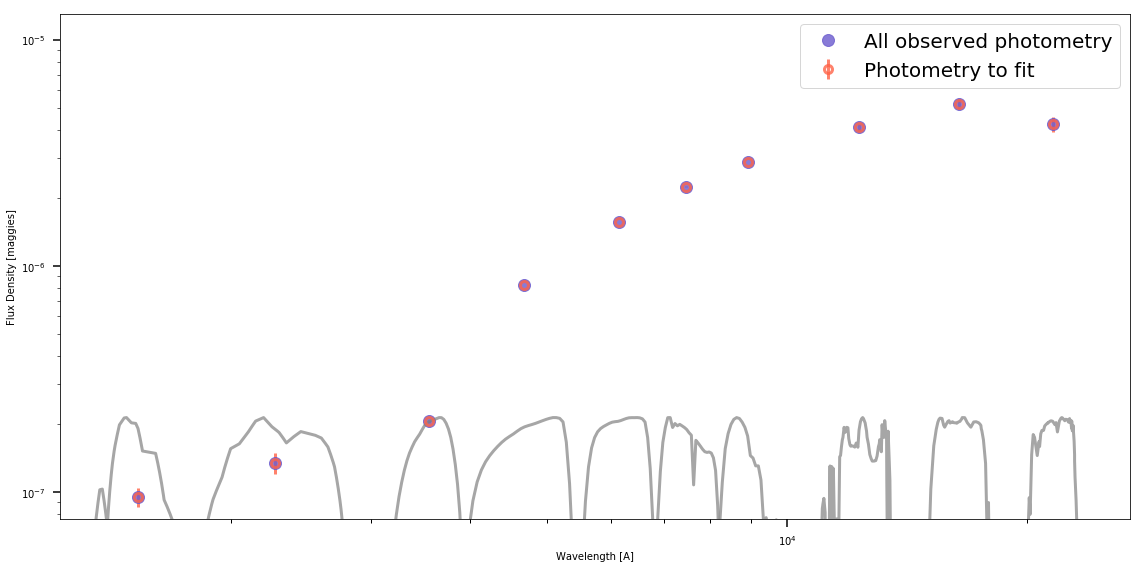

In [5]:
obs = build_obs(**run_params)

# Look at the contents of the obs dictionary
print("Obs Dictionary Keys:\n\n{}\n".format(obs.keys()))
print("--------\nFilter objects:\n")
print(obs["filters"])
#print(obs['phot_mask'])
# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4
figure(figsize=(16,8))

# plot all the data
plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

# overplot only the data we intend to fit
mask = obs["phot_mask"]
errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
print(obs['filters'][-2].transmission)
print(obs['filters'][-2].wavelength)
# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
xscale("log")
yscale("log")
legend(loc='best', fontsize=20)
tight_layout()

In [6]:
from prospect.models.templates import TemplateLibrary
TemplateLibrary.describe('continuity_sfh')

Free Parameters: (name: prior) 
-----------
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  logmass: <class 'prospect.models.priors.TopHat'>(mini=7,maxi=12)
  logsfr_ratios: <class 'prospect.models.priors.StudentT'>(mean=[0. 0.],scale=[0.3 0.3],df=[2 2])
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  sfh: 3 
  agebins: [[0.0, 8.0], [8.0, 9.0], [9.0, 10.0]] 
  dust_type: 0 
  zred: 0.1 
  mass: 1000000.0 <function logsfr_ratios_to_masses at 0x7fbf908a0488>
  imf_type: 2 


In [31]:
def build_model(object_redshift=None, ldist=83.6, fixed_metallicity = None, add_duste = True, 
                **extras):
    
    from prospect.models.sedmodel import SedModel
    from prospect.models.templates import TemplateLibrary, adjust_continuity_agebins
    from prospect.models import priors

    model_params = TemplateLibrary["continuity_sfh"]
    model_params.update(TemplateLibrary["dust_emission"])
    
    #model_params["duste_qpah"]["isfree"] = True
    #model_params["duste_umin"]['isfree'] = True
    #model_params["duste_gamma"]["isfree"] = True
    
    model_params["zred"]["init"] = 0.0
    model_params["logmass"]["init"] = 10
    model_params["mass"]["init"] = 1e9
    model_params["logsfr_ratios"]["init"] = [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
    model_params["agebins"]["init"] = [0.0, 8.0], [8.0, 9.0], [9.0, 10.0]
    model_params["dust2"]["init"] = 0.5
    model_params["logzsol"]["init"] = 0.1
    model_params["dust_type"]["init"] = 2
    
    model_params["logmass"]["prior"] = priors.TopHat(mini=7, maxi=12)
    model_params["logsfr_ratios"]["priors"] = priors.StudentT(mean=np.full(7,0),scale=np.full(7,0.3),df= np.full(7,2))
    model_params["duste_qpah"]["prior"] = priors.TopHat(mini=0.1, maxi=4.58)
    model_params["duste_umin"]["prior"] = priors.TopHat(mini=1e-1, maxi=15)
    model_params["duste_gamma"]["prior"] = priors.TopHat(mini=0.0, maxi=0.15)
    model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2)
    model_params["logzsol"]["prior"] = priors.TopHat(mini= -2, maxi = 0.19)

    model_params["logmass"]["disp_floor"] = 0.1
    model_params["dust2"]["disp_floor"] = 0.1
    model_params["duste_gamma"]["disp_floor"] = 0.3
    model_params["duste_qpah"]["disp_floor"] = 3
    model_params["duste_umin"]["disp_floor"] = 5
    

    if fixed_metallicity is not None:
        model_params["logzsol"]["isfree"] = False
        model_params["logzsol"]['init'] = fixed_metallicity 

    if object_redshift is not None:
        model_params["zred"]['isfree'] = False
        model_params["zred"]['init'] = object_redshift

    model_params["sfh"]["init"] = 0
    
    
    model_params=adjust_continuity_agebins(model_params, tuniv=13.466, nbins=8)
    agebins=model_params["agebins"]["init"]
    model = SedModel(model_params)
    
    return model

#run_params["object_redshift"] = 0.003
#run_params["fixed_metallicity"] = 0.5
#run_params["add_neb"] = False
    


In [32]:
model = build_model(**run_params)
print(model)
print("\nInitial free parameter vector theta:\n  {}\n".format(model.theta))
print("Initial parameter dictionary:\n{}".format(model.params))

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  logsfr_ratios: <class 'prospect.models.priors.StudentT'>(mean=[0. 0. 0. 0. 0. 0. 0.],scale=[0.3 0.3 0.3 0.3 0.3 0.3 0.3],df=[2. 2. 2. 2. 2. 2. 2.])
  logmass: <class 'prospect.models.priors.TopHat'>(mini=7,maxi=12)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  sfh: 0 
  agebins: [[ 0.          7.4772    ]
 [ 7.4772      8.        ]
 [ 8.          8.41173151]
 [ 8.41173151  8.82346301]
 [ 8.82346301  9.23519452]
 [ 9.23519452  9.64692603]
 [ 9.64692603 10.05865754]
 [10.05865754 10.12923861]] 
  add_dust_emission: True 
  duste_umin: 1.0 
  duste_qpah: 4.0 
  duste_gamma: 0.001 
  imf_type: 2 
  dust_type: 2 
  zred: 0.01835 
  mass: 1000000000.0 <function logsfr_ratios_to_masses at 0x7fbf908a0488>

Initial free parameter vector theta:
  [

In [9]:
def build_sps(zcontinuous=1, **extras):
    """
    :param zcontinuous: 
        A vlue of 1 insures that we use interpolation between SSPs to 
        have a continuous metallicity parameter (`logzsol`)
        See python-FSPS documentation for details
    """
    from prospect.sources import FastStepBasis
    sps = FastStepBasis(zcontinuous=zcontinuous)
    return sps

run_params["zcontinuous"] = 1

In [10]:
sps = build_sps(**run_params)

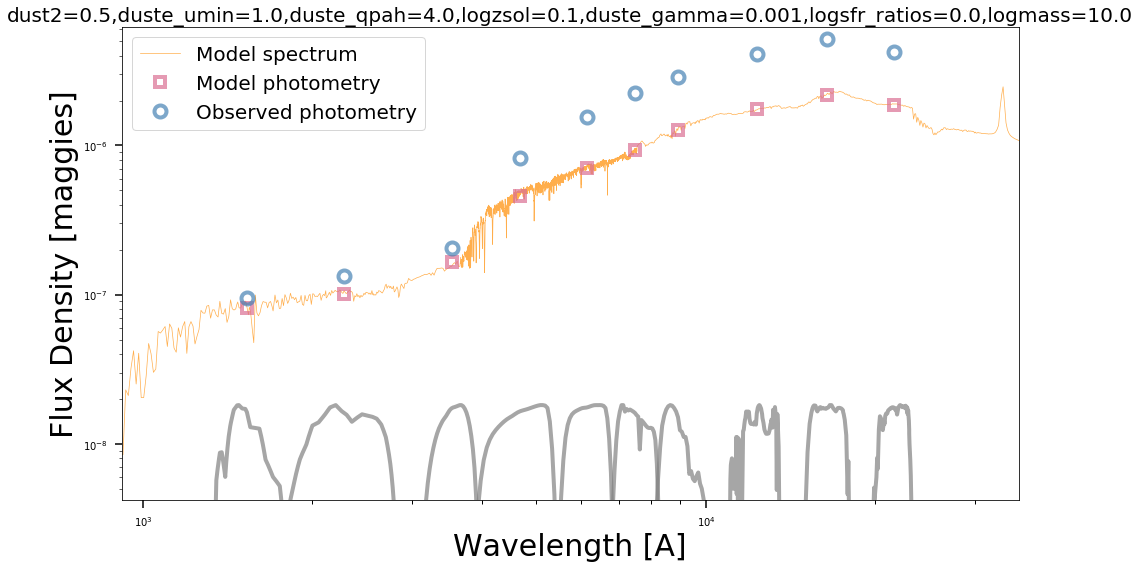

In [11]:
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]

# establish bounds
xmin, xmax = np.min(wphot)*0.6, np.max(wphot)/0.6
temp = np.interp(np.linspace(xmin,xmax,8000), wspec, initial_spec)
ymin, ymax = temp.min()*0.5, temp.max()/0.4
figure(figsize=(16,8))

# plot model + data
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='darkorange', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.7, ls='', lw=4,
         markerfacecolor='none', markeredgecolor='palevioletred', 
         markeredgewidth=4)
errorbar(wphot, obs['maggies'], 
         label='Observed photometry',
         marker='o', markersize=12, alpha=0.7, ls='', lw=4,
         ecolor='steelblue', markerfacecolor='none', markeredgecolor='steelblue', 
         markeredgewidth=4)
title(title_text, fontsize = 20)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=4, color='gray', alpha=0.7)

# prettify
xlabel('Wavelength [A]', fontsize = 30)
ylabel('Flux Density [maggies]', fontsize = 30)
xlim([xmin, xmax])
ylim([ymin, ymax])
matplotlib.rc('xtick', labelsize=25)
matplotlib.rc('ytick', labelsize=20) 
legend(loc='best', fontsize=20)
tight_layout()

In [12]:
from prospect.fitting import lnprobfn
#help(lnprobfn)

In [13]:
obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)
print(sps.ssp.libraries)

(b'mist', b'miles')


In [14]:
from prospect.fitting import fit_model

In [15]:
run_params["dynesty"] = True
run_params["optmization"] = False
run_params["emcee"] = False
run_params["nested_method"] = "rwalk"
run_params["nested_bound"] = 'multi'
run_params["nlive_init"] = 400
run_params["nlive_batch"] = 200
run_params["nested_dlogz_init"] = 0.05
run_params["nested_posterior_thresh"] = 0.05
run_params["nested_maxcall"] = int(1e7)

In [16]:
output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)
print('done dynesty in {0}s'.format(output["sampling"][1]))

iter: 2 | batch: 0 | nc: 1 | ncall: 2 | eff(%):  1.961 | logz: -2053819680.557 +/-  0.882 | dlogz:    inf >  0.050    /project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/fitting/nested.py:76: RuntimeWarning: invalid value encountered in sqrt
iter: 2517 | batch: 0 | nc: 1 | ncall: 873095 | eff(%):  0.288 | logz: 109.441 +/-  0.416 | dlogz:  0.000 >  0.050         


done dynesty (initial) in 20298.4951171875s


iter: 4933 | batch: 6 | nc: 461 | ncall: 2093232 | eff(%):  0.235 | loglstar: 122.398 < 130.204 < 127.741 | logz: 109.493 +/-  0.401 | stop:  1.160     

done dynesty (dynamic) in 18506.05745434761s
done dynesty in 38808.90226316452s


In [17]:
from prospect.io import write_results as writer
hfile = "6934_dynesty.h5"
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])

print('Finished')

Finished


/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/io/write_results.py:52: RuntimeWarning: Could not store paramfile text
/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/io/write_results.py:225: RuntimeWarning: Could not JSON serialize model_params, pickled instead
/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/io/write_results.py:254: UserWarning: Could not JSON serialize ndof, pickled instead


In [51]:
import prospect.io.read_results as reader
results_type = "dynesty"
result, obs, _ = reader.results_from("6934_dynesty.h5".format(results_type), dangerous=False)
print(result.keys())

dict_keys(['chain', 'model_params', 'paramfile_text', 'samples_id', 'prospector_version', 'lnlikelihood', 'optimization_results', 'information', 'logz', 'sampling_duration', 'logzerr', 'obs', 'logvol', 'weights', 'lnprobability', 'run_params', 'optimizer_duration', 'theta_labels', 'niter', 'model', 'efficiency', 'ncall'])


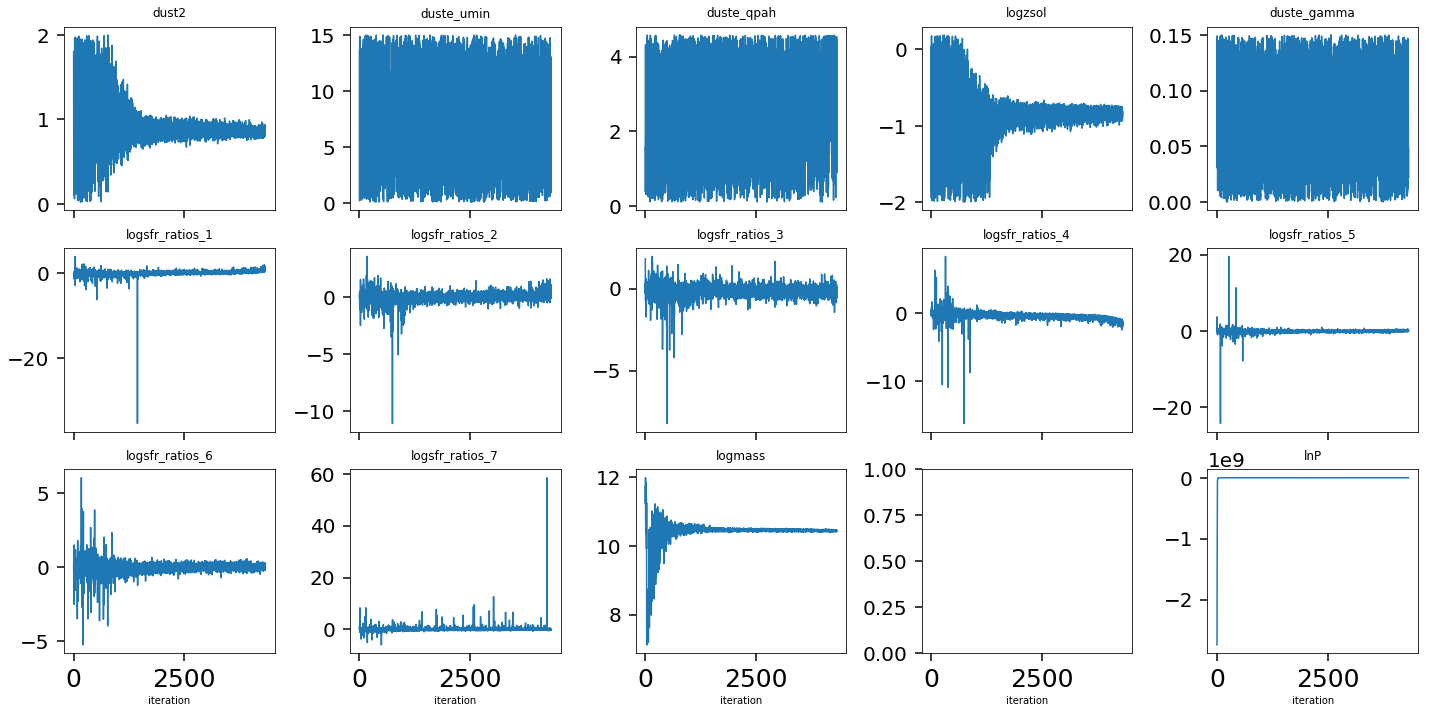

In [19]:
tracefig = reader.traceplot(result, figsize=(20,10))

In [53]:
print(result['weights'])
print(result['lnprobability'])
print(result['lnlikelihood'])

[0.         0.         0.         ... 0.0003609  0.00038376 0.00041324]
[-2.74494032e+09 -2.05381969e+09 -1.30657447e+09 ...  1.18234113e+02
  1.15827249e+02  1.18823851e+02]
[-2.74494031e+09 -2.05381968e+09 -1.30657445e+09 ...  1.30335294e+02
  1.30432897e+02  1.30485020e+02]


[-2.74494031e+09 -2.05381968e+09 -1.30657445e+09 ...  1.30335294e+02
  1.30432897e+02  1.30485020e+02]


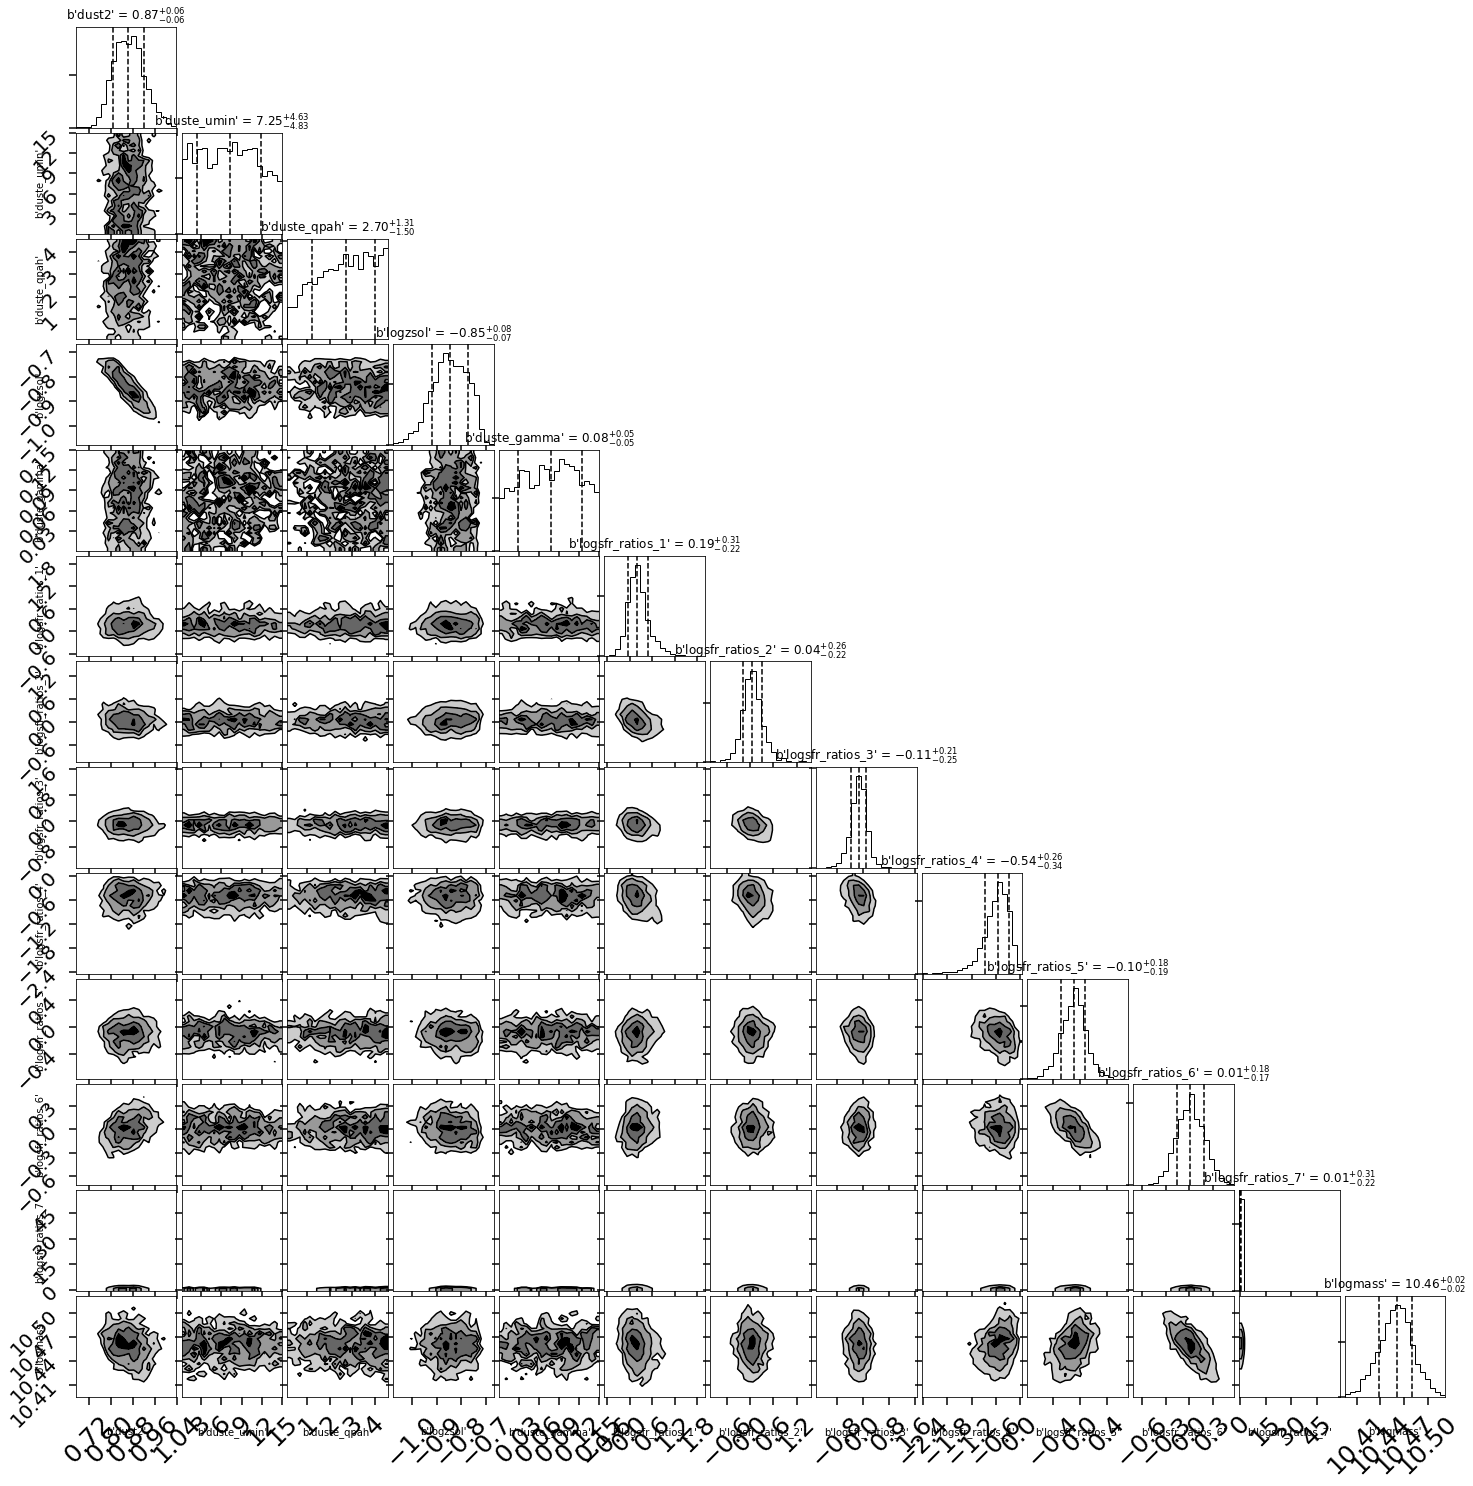

In [60]:
from dynesty import utils as dyfunc

result, obs, model = reader.results_from("6934_dynesty.h5")
imax = np.argmax(result['lnprobability'])

# The theta_max values give the most probable vales
theta_max = result['chain'][imax, :].copy()

cornerfig = reader.subcorner(result, start=2500, thin=1,
                      fig=subplots(13,13,figsize=(20,20))[0], fontsize=100)
print(result['lnlikelihood'])

In [24]:
sps = build_sps(**run_params)
model = build_model(**run_params)

flatchain = result['chain']

from prospect.utils.plotting import quantile
post_pcts = [quantile(flatchain[:, i], percents=50, weights=result.get("weights", None))
             for i in range(model.ndim)]

# These should have all the converged values
print(post_pcts)

mspec_conv, mphot_conv, _ = model.mean_model(post_pcts, obs, sps=sps)
print(mphot_conv)




[0.8718919041199864, 7.316414452052761, 2.699165580432089, -0.8536428277735519, 0.07822916237471375, 0.1476474893171112, 0.009845917642481933, -0.11358248266482482, -0.4625322523698879, -0.10430887152048333, -0.001680948651487393, 0.00712706908798962, 10.463323403365589]
[3.96826521e-08 6.52112198e-08 3.93955712e-06 4.74840452e-06
 3.85846208e-06 2.15337700e-07 8.19328075e-07 1.56073463e-06
 2.22873091e-06 2.89761130e-06]


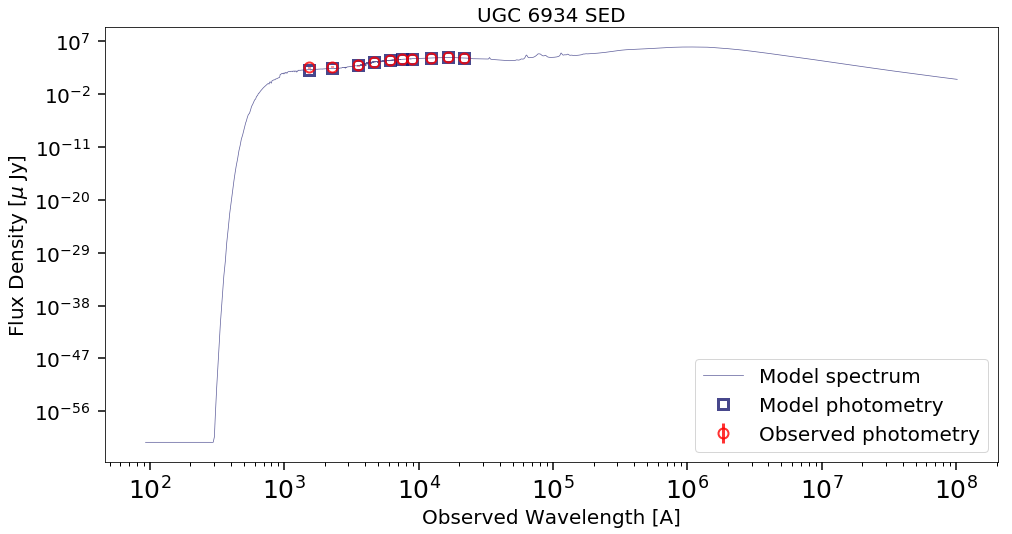

In [26]:
import matplotlib.pyplot as plt
wphot = obs["phot_wave"]

a = 1 + 0.01835

# Spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths.copy()
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]


maggies = obs['maggies']
mags_unc = obs['maggies_unc']

# Make plot of data and model
plt.figure(figsize=(16,8))

plt.loglog(wspec, mspec_conv*3631*1e6, label='Model spectrum',
       lw=0.7, color='midnightblue', alpha=0.7)
plt.errorbar(wphot, mphot_conv*3631*1e6, label='Model photometry',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='midnightblue', markeredgewidth=3)
plt.errorbar(wphot, obs['maggies']*3631*1e6, yerr=obs['maggies_unc']*3631*1e6, 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=2)
    



plt.xlabel('Observed Wavelength [A]',fontsize =20)
plt.ylabel(r'Flux Density [$\mu$ Jy]',fontsize =20)
plt.title('UGC 6934 SED',fontsize =20)

plt.legend(loc='best', fontsize=20)

plt.show()


In [14]:
run_params["optimize"] = False
run_params["emcee"] = True
run_params["dynesty"] = False
# Number of emcee walkers
run_params["nwalkers"] = 236
# Number of iterations of the MCMC sampling
run_params["niter"] = 12850
# Number of iterations in each round of burn-in
# After each round, the walkers are reinitialized based on the 
# locations of the highest probablity half of the walkers.
run_params["nburn"] = [1200, 1300, 1500]

In [15]:
output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)
print('done emcee in {0}s'.format(output["sampling"][1]))

number of walkers=236


/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/models/priors.py:90: RuntimeWarning: divide by zero encountered in log


done burn #0 (1200 iterations)
done burn #1 (1300 iterations)
done burn #2 (1500 iterations)
number of walkers=236
starting production
done production
done emcee in 45793.65801167488s


In [16]:
from prospect.io import write_results as writer
hfile = "UGC6934_mcmc.h5"
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])

print('Finished')

/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/io/write_results.py:52: RuntimeWarning: Could not store paramfile text
/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/io/write_results.py:225: RuntimeWarning: Could not JSON serialize model_params, pickled instead
/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/io/write_results.py:254: UserWarning: Could not JSON serialize ndof, pickled instead


Finished


In [46]:
import prospect.io.read_results as reader
results_type = "emcee"
# grab results (dictionary), the obs dictionary, and our corresponding models
# When using parameter files set `dangerous=True`
result, obs, _ = reader.results_from("UGC6934_mcmc.h5".format(results_type), dangerous=False)

# let's look at what's stored in the `result` dictionary
print(result.keys())

dict_keys(['chain', 'model_params', 'initial_theta', 'paramfile_text', 'run_params', 'prospector_version', 'sampling_initial_center', 'optimizer_duration', 'optimization_results', 'sampling_duration', 'acceptance', 'rstate', 'theta_labels', 'model', 'obs', 'lnprobability'])


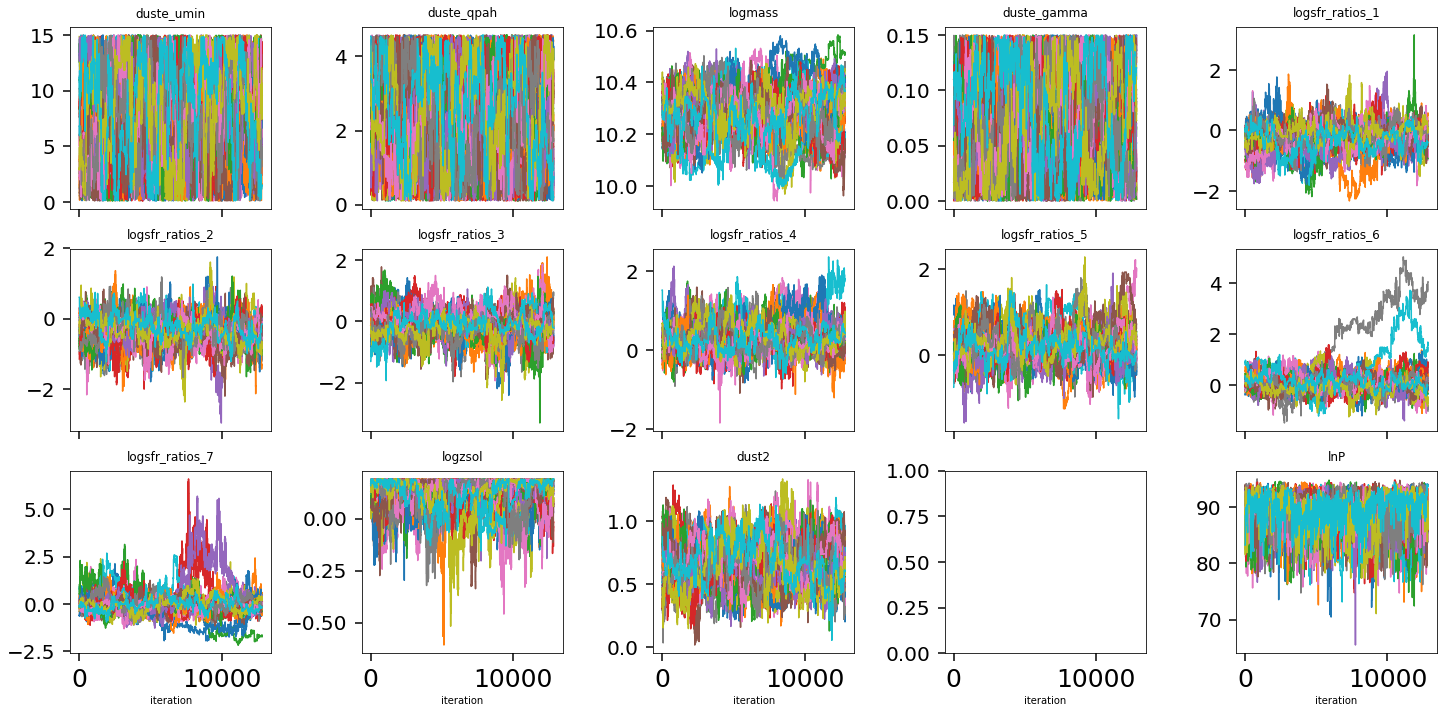

In [18]:
if results_type == "emcee":
    chosen = np.random.choice(result["run_params"]["nwalkers"], size=30, replace=False)
    tracefig = reader.traceplot(result, figsize=(20,10), chains=chosen)
else:
    tracefig = reader.traceplot(result, figsize=(20,10))


[[88.3138529  88.3138529  88.3138529  ... 88.66962478 88.66962478
  88.66962478]
 [91.86472896 91.86472896 91.64956923 ... 80.83218748 83.63806758
  83.63806758]
 [90.71746553 90.71746553 89.89607061 ... 92.01306182 92.01306182
  92.01306182]
 ...
 [91.14171725 91.14171725 91.14171725 ... 90.54395157 90.54395157
  90.54395157]
 [86.69396292 86.69396292 86.69396292 ... 91.49874318 86.93465241
  85.77544348]
 [91.39279918 91.39279918 91.39279918 ... 89.60155081 89.60155081
  89.60155081]]


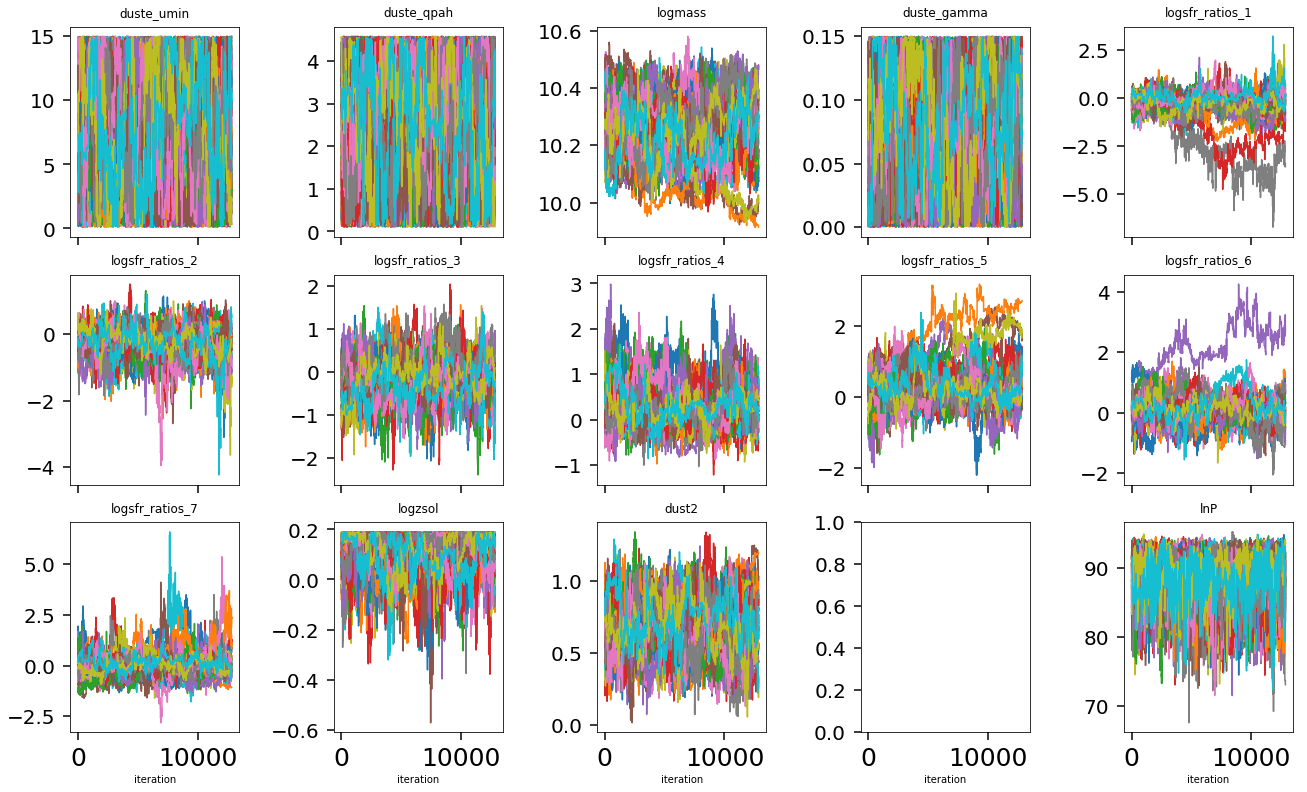

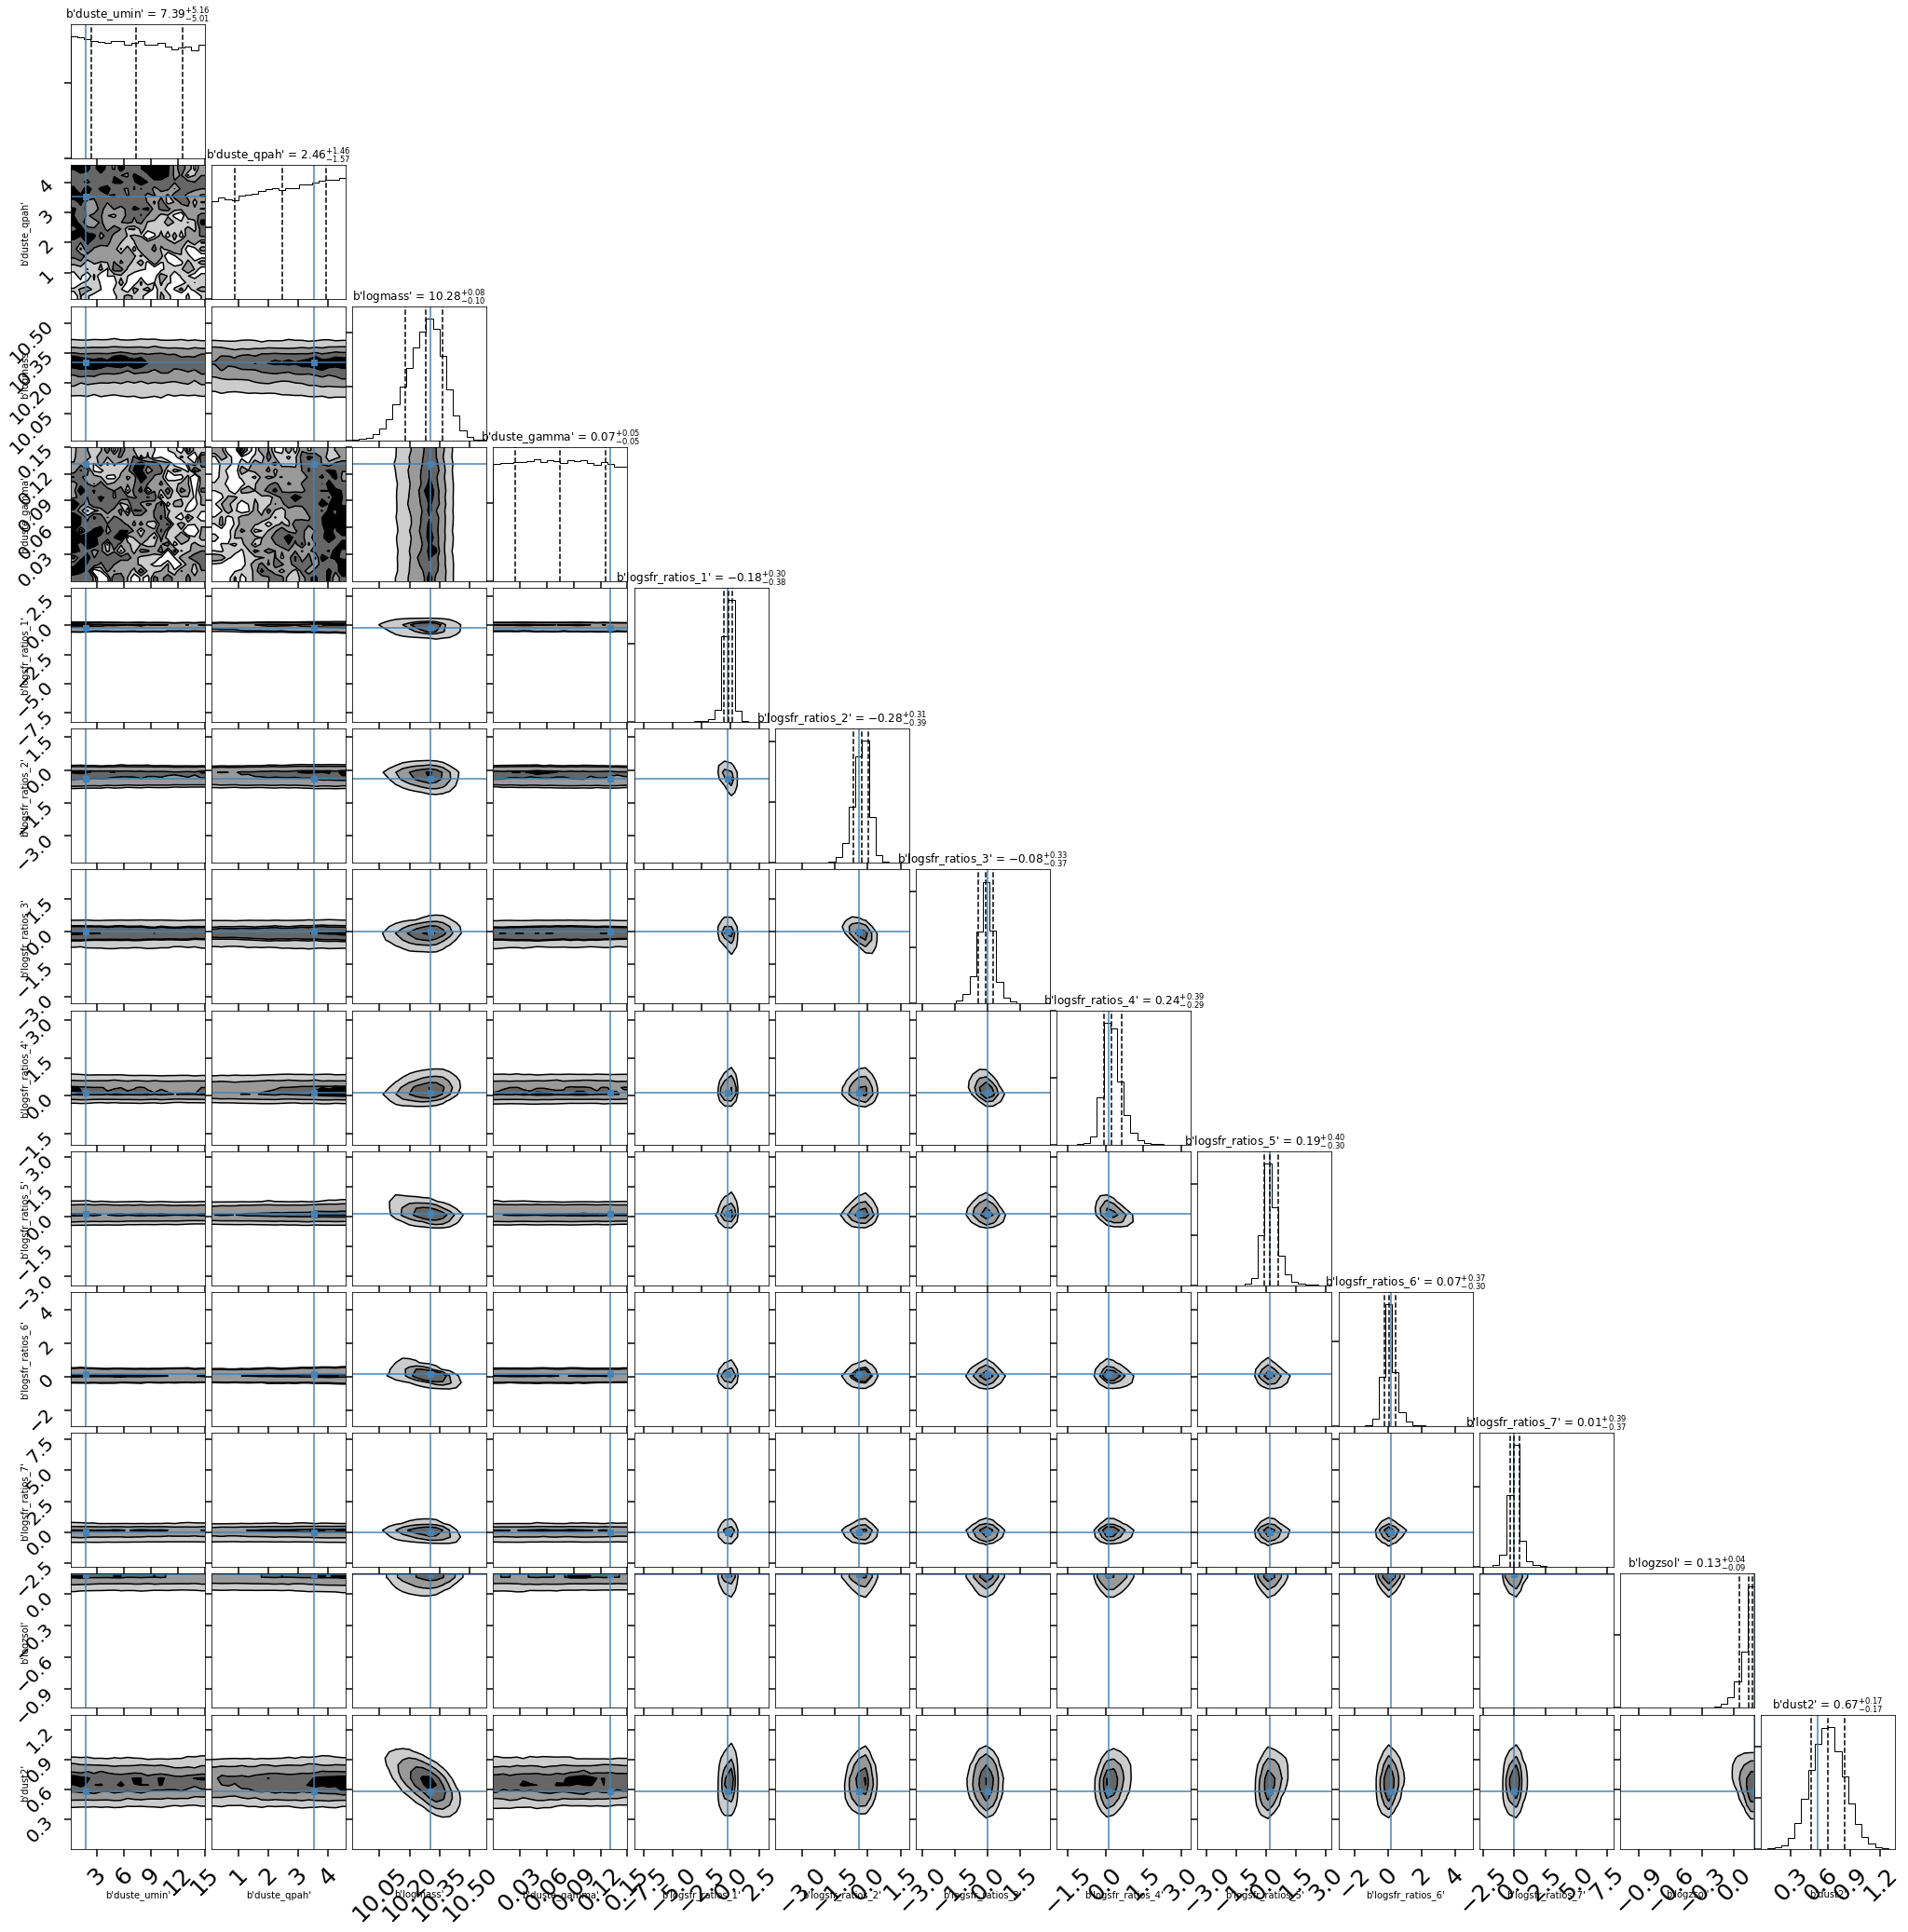

In [49]:
(res, topt) = output["sampling"]
import prospect.io.read_results as reader
res, obs, model = reader.results_from("UGC6934_mcmc.h5")
ind_max = res["lnprobability"].argmax()
chosen = np.random.choice(res["run_params"]["nwalkers"], size=50, replace=False)
walker, iteration = np.unravel_index(ind_max, res["lnprobability"].shape)
theta_max = res["chain"][walker, iteration, :]
tracefig = reader.traceplot(res, chains = chosen)
thin = 1
#cornerfig = reader.subcorner(res, , thin=thin)
cornerfig = reader.subcorner(res, thin=thin, truths=theta_max)
#print('MAP value: {}'.format(theta_max))
print(res['lnprobability'])

In [61]:
from matplotlib.pyplot import *
randint = np.random.randint
res_type = "emcee"
if res_type == "emcee":
    nwalkers, niter = run_params['nwalkers'], run_params['niter']
    theta = res['chain'][randint(nwalkers), randint(niter)]
    # Draw 100 random plots from mcmc
    #for i in range(100):
     #   theta = result['chain'][randint(nwalkers), randint(niter)]
        
      #  mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
    
       # loglog(wspec, mspec, label='Model spectrum (random draw)',
       #lw=0.7, color='navy', alpha=0.7)
        
        #errorbar(wphot, mphot, label='Model photometry (random draw)',
         #marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         #markerfacecolor='none', markeredgecolor='blue', 
         #markeredgewidth=3)

obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)
theta = model.theta.copy()
wspec = sps.wavelengths
wphot = obs["phot_wave"]
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

figure(figsize=(14,8))

xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4


#loglog(wspec, mspec, label='Model spectrum (random draw)',
 #      lw=0.7, color='navy', alpha=0.7)
loglog(wspec, mspec_map, lw=2, color='darkorange', label='Model spectrum (MAP)', alpha=0.7)
#errorbar(wphot, mphot, label='Model photometry (random draw)',
 #        marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
  #       markerfacecolor='none', markeredgecolor='blue', 
   #      markeredgewidth=3)
errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='palevioletred', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='steelblue', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='steelblue', 
         markeredgewidth=3)

#plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=4, color='gray', alpha=0.7)

xlabel('Wavelength [A]', fontsize = 30)
ylabel('Flux Density [maggies]', fontsize = 30)
xlim([xmin, xmax])
ylim([ymin, ymax])
matplotlib.rc('xtick', labelsize=25)
matplotlib.rc('ytick', labelsize=30) 
legend(loc='best', fontsize=20)
tight_layout()
tick_params(width = 3, length = 15, direction = 'in', which = "major", right = 'on', top = 'on', pad = 5)
tick_params(width = 2, length = 8, direction = 'in', which = "minor", right = 'on', top = 'on', pad = 5)

KeyError: 'nwalkers'

In [22]:
from prospect.models import transforms
A = ([[ 0.        ,  7.4772    ],
       [ 7.4772    ,  8.        ],
       [ 8.        ,  8.41173151],
       [ 8.41173151,  8.82346301],
       [ 8.82346301,  9.23519452],
       [ 9.23519452,  9.64692603],
       [ 9.64692603, 10.05865754],
       [10.05865754, 10.12923861]])
agebins = np.array(A)
print(agebins)
sfr = prospect.models.transforms.logsfr_ratios_to_sfrs(logmass=10.28,
                                                            logsfr_ratios=[-0.18, -0.28, -0.08, 0.24,
                                                                           0.19, 0.07, 0.01], agebins=agebins)
print(sfr)



[[ 0.          7.4772    ]
 [ 7.4772      8.        ]
 [ 8.          8.41173151]
 [ 8.41173151  8.82346301]
 [ 8.82346301  9.23519452]
 [ 9.23519452  9.64692603]
 [ 9.64692603 10.05865754]
 [10.05865754 10.12923861]]
[1.09146302 1.65199613 3.14781374 3.7845045  2.17775503 1.40607675
 1.1967654  1.1695237 ]


In [62]:
from prospect.models import transforms
A = ([[ 0.        ,  7.4772    ],
       [ 7.4772    ,  8.        ],
       [ 8.        ,  8.41173151],
       [ 8.41173151,  8.82346301],
       [ 8.82346301,  9.23519452],
       [ 9.23519452,  9.64692603],
       [ 9.64692603, 10.05865754],
       [10.05865754, 10.12923861]])
agebins = np.array(A)
print(agebins)
sfr = prospect.models.transforms.logsfr_ratios_to_sfrs(logmass=10.46,
                                                            logsfr_ratios=[0.15, 0.0098, -0.11, -0.46,
                                                                          -0.10, -0.002], agebins=agebins)
print(sfr)



[[ 0.          7.4772    ]
 [ 7.4772      8.        ]
 [ 8.          8.41173151]
 [ 8.41173151  8.82346301]
 [ 8.82346301  9.23519452]
 [ 9.23519452  9.64692603]
 [ 9.64692603 10.05865754]
 [10.05865754 10.12923861]]
[0.69619172 0.49286599 0.48186885 0.62076733 1.79031254 2.25386996
 2.26427335 2.26427335]
